# Multi-class Classification on Sensor Data

Importing Required libraries

In [425]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.metrics import f1_score,precision_score,accuracy_score,recall_score,roc_curve,auc

For using the provided data I thought of two ways:\
1). I combined the data in Node1 of every class and making an additional column for Response variable i.e our class.\
2). I combined the whole data of every class and making an additional column for Response variable i.e our class.

# First Approach

In [443]:
x1 = pd.read_csv("class1//node1.csv",header=None).transpose()

In [444]:
x1.shape

(7104, 3)

In [445]:
x2 = pd.read_csv("class2//node1.csv",header=None).transpose()

In [446]:
x2.shape

(11152, 3)

In [447]:
x3 = pd.read_csv("class3//node1.csv",header=None).transpose()

In [448]:
x3.shape

(17440, 3)

In [449]:
x4 = pd.read_csv("class4//node1.csv",header=None).transpose()

In [450]:
x4.shape

(16656, 3)

In [451]:
x5 = pd.read_csv("class5//node1.csv",header=None).transpose()

In [452]:
x5.shape

(12128, 3)

In [453]:
x1['Class'] = 1
x2['Class'] = 2
x3['Class'] = 3
x4['Class'] = 4
x5['Class'] = 5

In [454]:
x1.head()

,0,1,2,Class
0,-9.999645,-17.653510,39.568450,1
1,1.009946,5.876183,-26.706322,1
2,56.281012,-91.469115,30.900244,1
3,-99.211034,-374.855862,45.868870,1
4,35.287926,-90.171450,2.987267,1


In [455]:
#x1.columns = [ "Sensor1","Sensor2","Sensor3","Class"]

In [456]:
x2.head()

,0,1,2,Class
0,-44.939660,-113.821472,-4.406770,2
1,10.943525,-81.073125,74.000569,2
2,12.376247,-67.587118,-20.284065,2
3,10.579483,-70.109045,-29.825700,2
4,26.408328,-203.474749,122.155065,2


In [457]:
node1 = pd.concat([x1,x2,x3,x4,x5],axis=0,ignore_index=True)

In [458]:
node1.head()

,0,1,2,Class
0,-9.999645,-17.653510,39.568450,1
1,1.009946,5.876183,-26.706322,1
2,56.281012,-91.469115,30.900244,1
3,-99.211034,-374.855862,45.868870,1
4,35.287926,-90.171450,2.987267,1


In [459]:
node1.shape

(64480, 4)

In [460]:
node1.columns = ['Sensor1','Sensor2','Sensor3','Class']

In [461]:
node1.head() #Node1 is the structed dataset to work on in First approach.

,Sensor1,Sensor2,Sensor3,Class
0,-9.999645,-17.653510,39.568450,1
1,1.009946,5.876183,-26.706322,1
2,56.281012,-91.469115,30.900244,1
3,-99.211034,-374.855862,45.868870,1
4,35.287926,-90.171450,2.987267,1


In [462]:
X = node1.drop('Class',axis=1)
y = node1['Class']

Here we split the data in Training and Testing set and for validation we will use k-fold cross validation.

In [463]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1,stratify=y, random_state=1)

In [464]:
X_t = pd.DataFrame(X_train)

In [465]:
X_t.columns=['Sensor1','Sensor2','Sensor3']

In [466]:
X_t.head()

,Sensor1,Sensor2,Sensor3
21837,-73.414857,-56.794792,24.839097
7756,24.728998,-109.634915,90.061351
31652,-76.038077,-32.111297,48.489157
2873,8.747484,14.657431,34.584779
28110,-73.247516,-56.875520,25.247181


Here we perform some exploratory data analysis to know the data properly.

C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


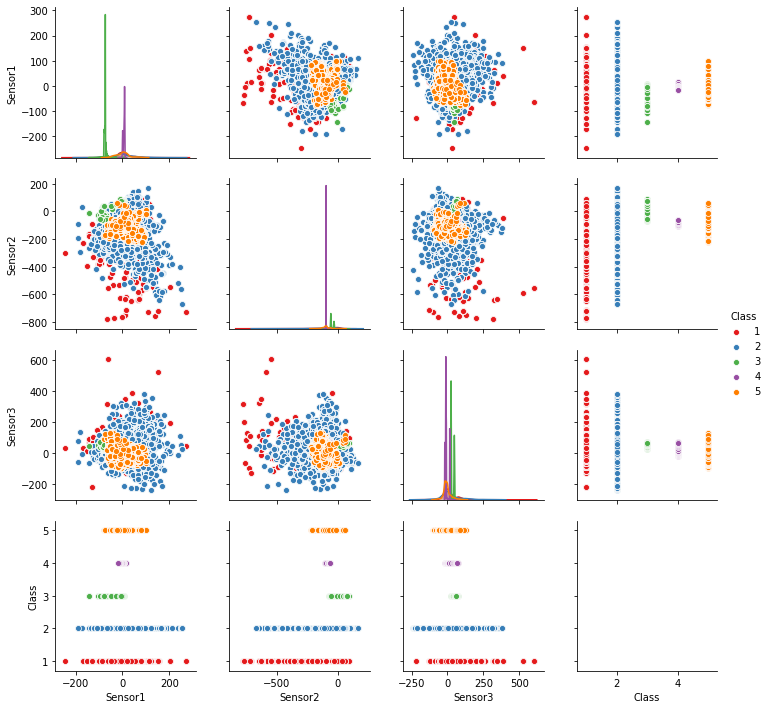

In [467]:
sns.pairplot(node1,hue='Class',palette='Set1')

In the pairplots we plot the scatter plots of all combinations of our variables and we see that the plots doesn't show any strong correlation which can futher be seen in the heatmap plotted with correlations.

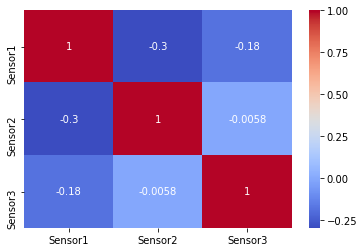

In [468]:
sns.heatmap(X.corr(),cmap='coolwarm',annot=True)

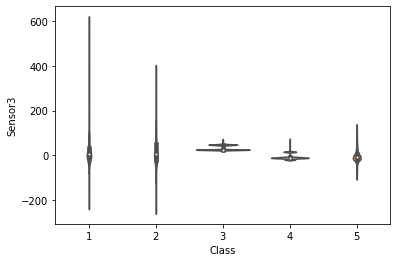

In [469]:
sns.violinplot(x="Class", y="Sensor3", data=node1,palette='rainbow')

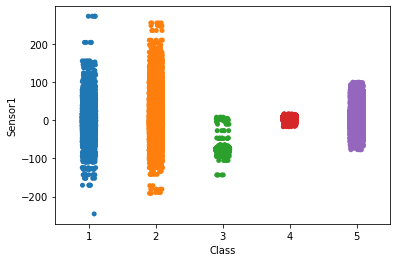

In [470]:
sns.stripplot(x="Class", y="Sensor1", data=node1,jitter=True)

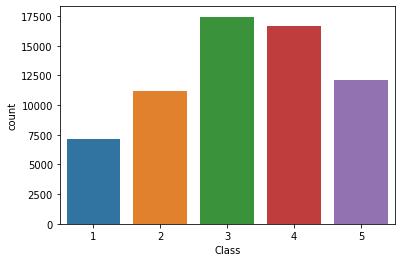

In [471]:
sns.countplot(node1['Class'])

We can see from the countplot that the classes are balanced i.e there is no class with very less observations.

Now we scale our data to get 0 mean and unit variance

In [475]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The model I am going to use here is RandomForest as it is inherently a multi-class classifier.\
But to select the best model we need to tune the hyperparameters( here we will tune tree depth and number of trees) and select the best parameters using cross-validation based on F1-score. So, we use cross-validation to hypertune the parameters and testing error to find the best model.

In [374]:
max_depth_list = [2,5,10,15]
n_trees_list = [10, 20, 50, 100,500]
score_list = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']
max_f1 = 0
n_trees = 100
for n_trees in n_trees_list:
    for d in max_depth_list:
        print("\nNumber of Trees: ", n_trees, " Max_Depth: ", d)
        rfc = RandomForestClassifier(n_estimators=n_trees, criterion="gini", \
                                     max_depth=d, min_samples_split=2, \
                                     min_samples_leaf=1, max_features='auto', \
                                     n_jobs=4, bootstrap=True,random_state=12345)
        scores = cross_validate(rfc, X_train, y_train, scoring=score_list, \
                                return_train_score=False,cv=5)
        print("{:.<13s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
        for s in score_list:
            var = "test_"+s
            mean = scores[var].mean()
            std = scores[var].std()
            print("{:.<13s}{:>7.4f}{:>10.4f}".format(s, mean, std))
        if mean > max_f1:
            max_f1 = mean
            best_depth = d
            best_n_trees = n_trees
print("\nBest based on F1-Score from a forest with ", best_n_trees, " trees.")
print("Best Depth (trees) = ", best_depth)


Number of Trees:  10  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5898    0.0011
recall_macro. 0.4887    0.0014
precision_macro 0.4512    0.0013
f1_macro..... 0.4314    0.0019

Number of Trees:  10  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7652    0.0021
recall_macro. 0.6732    0.0033
precision_macro 0.7573    0.0075
f1_macro..... 0.6522    0.0051

Number of Trees:  10  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8797    0.0009
recall_macro. 0.8331    0.0014
precision_macro 0.8439    0.0015
f1_macro..... 0.8367    0.0011

Number of Trees:  10  Max_Depth:  15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9442    0.0015
recall_macro. 0.9239    0.0021
precision_macro 0.9295    0.0027
f1_macro..... 0.9262    0.0023

Number of Trees:  20  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5939    0.0009
recall_macro. 0.4939    0.0009
precision_macro 0.4540    0.0014
f1_macro..... 0.4385    0.0012

Number of Trees:  20  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7641    0.0015
recall_macro. 0.6699    0.0019
precision_macro 0.7430    0.0079
f1_macro..... 0.6381    0.0030

Number of Trees:  20  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8809    0.0006
recall_macro. 0.8344    0.0013
precision_macro 0.8453    0.0010
f1_macro..... 0.8380    0.0011

Number of Trees:  20  Max_Depth:  15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9463    0.0010
recall_macro. 0.9268    0.0017
precision_macro 0.9324    0.0017
f1_macro..... 0.9291    0.0016

Number of Trees:  50  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.6015    0.0013
recall_macro. 0.5001    0.0011
precision_macro 0.4601    0.0016
f1_macro..... 0.4464    0.0013

Number of Trees:  50  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7751    0.0026
recall_macro. 0.6799    0.0024
precision_macro 0.7506    0.0028
f1_macro..... 0.6477    0.0030

Number of Trees:  50  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8815    0.0011
recall_macro. 0.8349    0.0016
precision_macro 0.8458    0.0019
f1_macro..... 0.8386    0.0017

Number of Trees:  50  Max_Depth:  15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9487    0.0017
recall_macro. 0.9303    0.0023
precision_macro 0.9358    0.0022
f1_macro..... 0.9325    0.0022

Number of Trees:  100  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5911    0.0010
recall_macro. 0.4916    0.0010
precision_macro 0.4481    0.0016
f1_macro..... 0.4352    0.0012

Number of Trees:  100  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7705    0.0007
recall_macro. 0.6750    0.0008
precision_macro 0.7642    0.0044
f1_macro..... 0.6413    0.0008

Number of Trees:  100  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8818    0.0010
recall_macro. 0.8352    0.0012
precision_macro 0.8461    0.0017
f1_macro..... 0.8389    0.0013

Number of Trees:  100  Max_Depth:  15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9489    0.0012
recall_macro. 0.9307    0.0017
precision_macro 0.9362    0.0016
f1_macro..... 0.9329    0.0016

Number of Trees:  500  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5938    0.0011
recall_macro. 0.4929    0.0011
precision_macro 0.4519    0.0019
f1_macro..... 0.4371    0.0016

Number of Trees:  500  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7775    0.0005
recall_macro. 0.6816    0.0007
precision_macro 0.7588    0.0052
f1_macro..... 0.6486    0.0010

Number of Trees:  500  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8822    0.0009
recall_macro. 0.8358    0.0011
precision_macro 0.8466    0.0016
f1_macro..... 0.8395    0.0013

Number of Trees:  500  Max_Depth:  15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9497    0.0015
recall_macro. 0.9318    0.0020
precision_macro 0.9373    0.0018
f1_macro..... 0.9340    0.0019

Best based on F1-Score from a forest with  500  trees.
Best Depth (trees) =  15


So, we get the best model for tree depth of 15 and number of trees = 500 but there is very less difference in the values of F1-score in 100 trees and depth of 15. So we use n_estimators=100 and depth =15 in our model.

In [ ]:
classifier1 = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42,max_depth=15)
classifier1.fit(X_train, y_train)

In [395]:
pred1 = classifier1.predict(X_test)

In [396]:
pred2 = classifier1.predict(X_train)

In [397]:
f1_score(y_test,pred1,average='macro')

0.943437750506431

In [398]:
f1_score(y_train,pred2,average='macro')

0.9443484580408837

In [399]:
precision_score(y_test,pred1,average='macro')

0.9458326560082643

In [400]:
precision_score(y_train,pred2,average='macro')

0.9470476889750552

In [402]:
accuracy_score(y_train,pred2)

0.9574836411070711

In [401]:
accuracy_score(y_test,pred1)

0.9574660633484163

In [393]:
scores2 = cross_val_score(classifier1, X_train, y_train, scoring='accuracy',cv=5)

In [392]:
scores2.mean()

0.9482793770833761

We see that the Accuracy on train, test and validation set is quite similar. so, our model is working better and we are on the right track.

In [250]:
scores = cross_val_score(classifier, X_train, y_train, scoring='f1_macro',cv=5)

In [252]:
scores.mean()

0.7906007759148764

In [403]:
pred = classifier1.predict(X_test)

Next we plot the confusion matrixx and classification report

In [404]:
print(confusion_matrix(y_test,pred))

[[337  26   0   0  25]
 [ 39 453   0   1  28]
 [  0   0 831   0   0]
 [  0   0   0 848   3]
 [  7  10   0   2 705]]


In [405]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.88      0.87      0.87       388
           2       0.93      0.87      0.90       521
           3       1.00      1.00      1.00       831
           4       1.00      1.00      1.00       851
           5       0.93      0.97      0.95       724

    accuracy                           0.96      3315
   macro avg       0.95      0.94      0.94      3315
weighted avg       0.96      0.96      0.96      3315



Majority of the classes are predicted correctly as we see from the confusion matrix and our precision, recall and f1-score is also good for all classes.

In [406]:
feature_importances = pd.DataFrame(classifier1.feature_importances_,
                                   index = X_t.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

Now we check the feature importance of our variables

In [407]:
feature_importances

,importance
Sensor2,0.44205
Sensor3,0.28792
Sensor1,0.27003


No handles with labels found to put in legend.


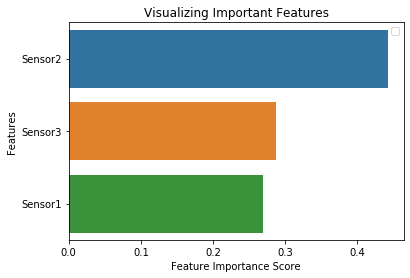

In [408]:
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

As we can see from the plot tha all variables are important and there is no need to drop any variable.

Now we try another model(Decision Tree)

In [409]:
from sklearn.tree import DecisionTreeClassifier

In [410]:
dtree = DecisionTreeClassifier(max_depth=10)

In [411]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [412]:
predictions = dtree.predict(X_test)

In [414]:
predictions1 = dtree.predict(X_train)

In [413]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           1       0.65      0.61      0.63       388
           2       0.70      0.63      0.67       521
           3       0.99      1.00      0.99       831
           4       0.99      0.99      0.99       851
           5       0.83      0.91      0.87       724

    accuracy                           0.87      3315
   macro avg       0.83      0.83      0.83      3315
weighted avg       0.87      0.87      0.87      3315



In [415]:
accuracy_score(y_train,predictions1)

0.8735298330737651

In [416]:
accuracy_score(y_test,predictions)

0.8739064856711916

In [417]:
scores3 = cross_val_score(dtree, X_train, y_train, scoring='accuracy',cv=5)

In [418]:
scores3.mean()

0.8705338473616819

Comparing the accuracy of Decision Tree and Random Forest we choose Random forest model.

In [207]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(node1.columns[0:3])
features

['Sensor1', 'Sensor2', 'Sensor3']

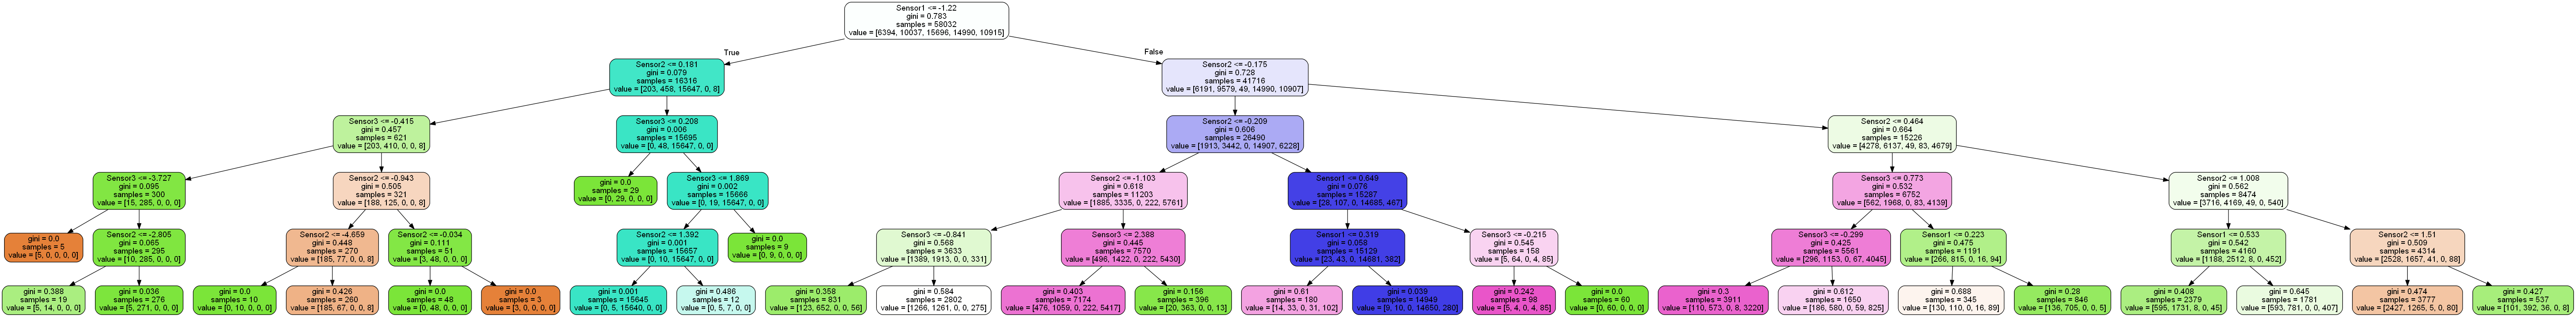

In [208]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

# Second Approach 

Similar steps as that of First approach are carried out. In this case whole data is considered.

In [320]:
all_files = glob.glob("class1/*.csv")

In [321]:
l = []

In [322]:
for filename in all_files:
    df = pd.read_csv(filename, header=None).transpose()
    l.append(df)

In [323]:
frame1 = pd.concat(l, axis=0, ignore_index=True)

In [324]:
frame1['Class'] = 1

In [326]:
frame1.shape

(36128, 4)

In [307]:
all_files1 = glob.glob("class2/*.csv")
m = []
for filename in all_files1:
    df1 = pd.read_csv(filename, header=None).transpose()
    m.append(df1)
frame2 = pd.concat(m, axis=0, ignore_index=True)
frame2['Class'] = 2

In [308]:
frame2.shape

(55248, 4)

In [310]:
all_files2 = glob.glob("class3/*.csv")
n = []
for filename in all_files2:
    df2 = pd.read_csv(filename, header=None).transpose()
    n.append(df2)
frame3 = pd.concat(n, axis=0, ignore_index=True)
frame3['Class'] = 3

In [311]:
all_files3 = glob.glob("class4/*.csv")
o = []
for filename in all_files3:
    df3 = pd.read_csv(filename, header=None).transpose()
    o.append(df3)
frame4 = pd.concat(o, axis=0, ignore_index=True)
frame4['Class'] = 4

In [312]:
all_files4 = glob.glob("class5/*.csv")
p = []
for filename in all_files4:
    df1 = pd.read_csv(filename, header=None).transpose()
    p.append(df1)
frame5 = pd.concat(p, axis=0, ignore_index=True)
frame5['Class'] = 5

In [347]:
data = pd.concat([frame1,frame2,frame3,frame4,frame5],axis=0,ignore_index=True)

In [348]:
data.columns = ['Sensor1','Sensor2','Sensor3','Class']

In [349]:
X1.shape

(331424, 3)

In [350]:
X1 = data.drop('Class',axis=1)
y1 = data['Class']

In [358]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.01,random_state=1)

C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


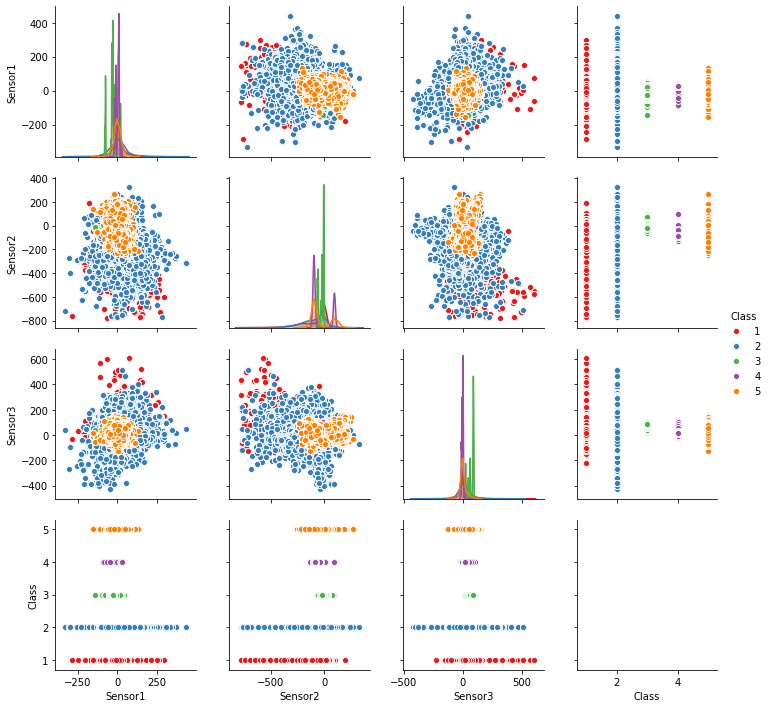

In [360]:
sns.pairplot(data,hue='Class',palette='Set1')

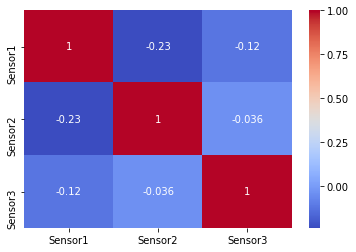

In [361]:
sns.heatmap(X1.corr(),cmap='coolwarm',annot=True)

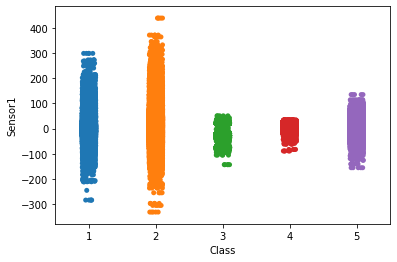

In [363]:
sns.stripplot(x="Class", y="Sensor1", data=data,jitter=True)

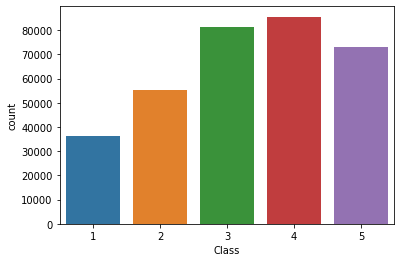

In [364]:
sns.countplot(data['Class'])

In [365]:
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

In [419]:
max_depth_list = [2,5,10]
n_trees_list = [10, 20, 50, 100]
score_list = ['accuracy', 'recall_macro', 'precision_macro', 'f1_macro']
max_f1 = 0
n_trees = 100
for n_trees in n_trees_list:
    for d in max_depth_list:
        print("\nNumber of Trees: ", n_trees, " Max_Depth: ", d)
        rfc = RandomForestClassifier(n_estimators=n_trees, criterion="gini", \
                                     max_depth=d, min_samples_split=2, \
                                     min_samples_leaf=1, max_features='auto', \
                                     n_jobs=4, bootstrap=True,random_state=12345)
        scores = cross_validate(rfc, X1_train, y1_train, scoring=score_list, \
                                return_train_score=False,cv=5)
        print("{:.<13s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
        for s in score_list:
            var = "test_"+s
            mean = scores[var].mean()
            std = scores[var].std()
            print("{:.<13s}{:>7.4f}{:>10.4f}".format(s, mean, std))
        if mean > max_f1:
            max_f1 = mean
            best_depth = d
            best_n_trees = n_trees
print("\nBest based on F1-Score from a forest with ", best_n_trees, " trees.")
print("Best Depth (trees) = ", best_depth)


Number of Trees:  10  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5898    0.0011
recall_macro. 0.4887    0.0014
precision_macro 0.4512    0.0013
f1_macro..... 0.4314    0.0019

Number of Trees:  10  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7652    0.0021
recall_macro. 0.6732    0.0033
precision_macro 0.7573    0.0075
f1_macro..... 0.6522    0.0051

Number of Trees:  10  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8797    0.0009
recall_macro. 0.8331    0.0014
precision_macro 0.8439    0.0015
f1_macro..... 0.8367    0.0011

Number of Trees:  20  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5939    0.0009
recall_macro. 0.4939    0.0009
precision_macro 0.4540    0.0014
f1_macro..... 0.4385    0.0012

Number of Trees:  20  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7641    0.0015
recall_macro. 0.6699    0.0019
precision_macro 0.7430    0.0079
f1_macro..... 0.6381    0.0030

Number of Trees:  20  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8809    0.0006
recall_macro. 0.8344    0.0013
precision_macro 0.8453    0.0010
f1_macro..... 0.8380    0.0011

Number of Trees:  50  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.6015    0.0013
recall_macro. 0.5001    0.0011
precision_macro 0.4601    0.0016
f1_macro..... 0.4464    0.0013

Number of Trees:  50  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7751    0.0026
recall_macro. 0.6799    0.0024
precision_macro 0.7506    0.0028
f1_macro..... 0.6477    0.0030

Number of Trees:  50  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8815    0.0011
recall_macro. 0.8349    0.0016
precision_macro 0.8458    0.0019
f1_macro..... 0.8386    0.0017

Number of Trees:  100  Max_Depth:  2


C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\birha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

Metric.......  Mean    Std. Dev.
accuracy..... 0.5911    0.0010
recall_macro. 0.4916    0.0010
precision_macro 0.4481    0.0016
f1_macro..... 0.4352    0.0012

Number of Trees:  100  Max_Depth:  5
Metric.......  Mean    Std. Dev.
accuracy..... 0.7705    0.0007
recall_macro. 0.6750    0.0008
precision_macro 0.7642    0.0044
f1_macro..... 0.6413    0.0008

Number of Trees:  100  Max_Depth:  10
Metric.......  Mean    Std. Dev.
accuracy..... 0.8818    0.0010
recall_macro. 0.8352    0.0012
precision_macro 0.8461    0.0017
f1_macro..... 0.8389    0.0013

Best based on F1-Score from a forest with  100  trees.
Best Depth (trees) =  10


No handles with labels found to put in legend.


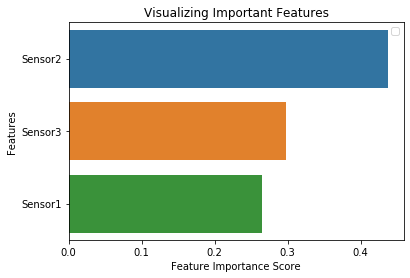

In [373]:
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 42,max_depth=10)
classifier.fit(X1_train, y1_train)
pred1 = classifier.predict(X1_test)
pred2 = classifier.predict(X1_train)
feature_importances1 = pd.DataFrame(classifier.feature_importances_,
                                   index = X1.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
sns.barplot(x=feature_importances1['importance'], y=feature_importances1.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [370]:
print(confusion_matrix(y1_test,pred1))

[[230 116   2   1  39]
 [ 82 367   3   1  68]
 [  0   1 829   0   1]
 [  0   1   0 842   8]
 [  9  45   1   9 660]]


In [394]:
accuracy_score(y1_train,pred2)

0.8855410854319753

In [371]:
accuracy_score(y1_test,pred1)

0.8832579185520362

In [376]:
scores1 = cross_val_score(classifier, X1_train, y1_train, scoring='accuracy',cv=5)

In [377]:
scores1.mean()

0.8819568944236866

In [372]:
print(classification_report(y1_test,pred1))

              precision    recall  f1-score   support

           1       0.72      0.59      0.65       388
           2       0.69      0.70      0.70       521
           3       0.99      1.00      1.00       831
           4       0.99      0.99      0.99       851
           5       0.85      0.91      0.88       724

    accuracy                           0.88      3315
   macro avg       0.85      0.84      0.84      3315
weighted avg       0.88      0.88      0.88      3315

